In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nilan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LOAD THE DATA

In [87]:
#Load the data

data = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [88]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [89]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [90]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [91]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [92]:
#We will drop the null record

data.dropna(inplace=True)

In [93]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [94]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [95]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

DATATYPES OF THE FEATURES

In [96]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

LETS CHECK THE BALANCE BETWEEN THE 2 CLASSES IN THE 'FEEDBACK' COLUMN 

In [97]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


feedback **0 is negative review** and **1 is positive review**

As we saw above the minority class has less no. of data points (256) as compared to 2893 of the majority class. Now we will try different dataset balancing techniques to see if doing that increases the performance of our model.

UPSAMPLING TECHNIQUE

In [98]:
# Let us again check the distribution of the classes in our target variable 'Feedback'

#print(data['feedback'].value_counts())


In [99]:
# Now lets separate the minority and majority classes in the feedback column 

#data_majority = data[data['feedback'] == 1]
#data_minority = data[data['feedback'] == 0]

In [100]:
#data_majority.shape, data_minority.shape

In [101]:
#data_minority_up = resample(data_minority,
#                             replace=True, 
 #                            n_samples=len(data_majority), 
  #                           random_state=123)

In [102]:
#data_upsampled = pd.concat([data_majority, data_minority_up])

In [103]:
#data_upsampled['feedback'].value_counts()

In [104]:
#data_upsampled

SMOTE TECHNIQUE

In [105]:
# SMOTE technique

#Split the data into features and target variable

X = data.drop('feedback', axis=1)
y = data['feedback']

In [106]:
#Split the data into training and testing set

X_train_smo, X_test_smo, y_train_smo, y_test_smo = train_test_split(X, y, test_size=0.3, random_state=42)

In [107]:
X_train_smo.shape, X_test_smo.shape, y_train_smo.shape, y_test_smo.shape

((2204, 5), (945, 5), (2204,), (945,))

In [108]:
# converting the date column (which is in string format) to numeric format so that it can be convered to float when we apply SMOTE
X_train_smo['date'] = pd.to_datetime(X_train_smo['date'], format = '%d-%b-%y', errors='coerce')
X_test_smo['date'] = pd.to_datetime(X_test_smo['date'], format = '%d-%b-%y', errors='coerce')

X_train_smo['date'] = X_train_smo['date'].astype(int) / 10**9
X_test_smo['date'] = X_test_smo['date'].astype(int) / 10**9  # Convert to seconds since epoch  # Convert to seconds since epoch

In [109]:
# Step 1: Convert 'variation' column (categorical text) to numeric using one-hot encoding or label encoding
X_train_smo = pd.get_dummies(X_train_smo, columns=['variation'], drop_first=True)
X_test_smo = pd.get_dummies(X_test_smo, columns=['variation'], drop_first=True)

# Ensure both training and testing sets have the same columns after encoding
X_train_smo, X_test_smo = X_train_smo.align(X_test_smo, join='left', axis=1)
X_test_smo.fillna(0, inplace=True)  # Fill missing columns in test set with 0

In [110]:
# Step 2: Convert 'verified_reviews' column (text) to numeric using TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)  # Limit features for efficiency

# Fit TF-IDF on training data and transform both training and testing sets
verified_reviews_train_tfidf = tfidf.fit_transform(X_train_smo['verified_reviews']).toarray()
verified_reviews_test_tfidf = tfidf.transform(X_test_smo['verified_reviews']).toarray()

# Step 2: Create DataFrames for the TF-IDF features
tfidf_train_df = pd.DataFrame(verified_reviews_train_tfidf, 
                              columns=[f'tfidf_{i}' for i in range(verified_reviews_train_tfidf.shape[1])],
                              index=X_train_smo.index)

tfidf_test_df = pd.DataFrame(verified_reviews_test_tfidf, 
                             columns=[f'tfidf_{i}' for i in range(verified_reviews_test_tfidf.shape[1])],
                             index=X_test_smo.index)

# Step 3: Drop the original 'verified_reviews' column
X_train_smo = X_train_smo.drop('verified_reviews', axis=1)
X_test_smo = X_test_smo.drop('verified_reviews', axis=1)

# Step 4: Concatenate the TF-IDF features with the original DataFrames
X_train_smo = pd.concat([X_train_smo, tfidf_train_df], axis=1)
X_test_smo = pd.concat([X_test_smo, tfidf_test_df], axis=1)

In [111]:
X_train_smo

,rating,date,length,variation_Black Dot,variation_Black Plus,variation_Black Show,variation_Black Spot,variation_Charcoal Fabric,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
2253,5,1.532909e+09,5,False,False,False,False,False,True,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1455,5,1.532909e+09,63,False,False,True,False,False,False,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1499,5,1.532909e+09,25,False,False,True,False,False,False,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2561,4,1.532909e+09,272,True,False,False,False,False,False,False,...,0.172254,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
550,5,1.528934e+09,19,False,False,False,False,False,False,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,5,1.532909e+09,118,False,False,False,False,False,False,False,...,0.000000,0.0,0.0,0.22917,0.0,0.0,0.0,0.0,0.0,0.0
1096,5,1.532909e+09,28,False,False,False,True,False,False,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1131,5,1.532822e+09,92,False,False,False,True,False,False,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1295,5,1.532304e+09,21,False,False,False,False,False,False,False,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
from imblearn.over_sampling import SMOTE

In [113]:
print(X_train_smo.dtypes)

rating                     int64
date                     float64
length                     int64
variation_Black  Dot        bool
variation_Black  Plus       bool
                          ...   
tfidf_495                float64
tfidf_496                float64
tfidf_497                float64
tfidf_498                float64
tfidf_499                float64
Length: 518, dtype: object


In [114]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train_smo, y_train_smo)

In [115]:
X_train_res.shape, y_train_res.shape

((4080, 518), (4080,))

ADSYN TECHNIQUE

SMOTE + ENN TECHNIQUE

In [116]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

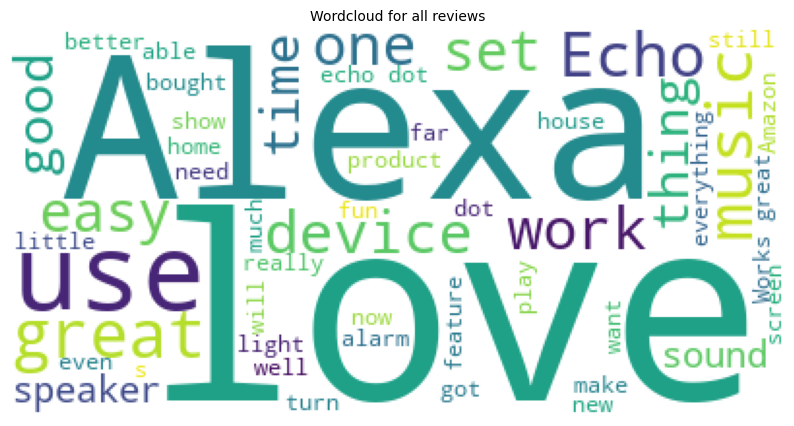

In [117]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [118]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

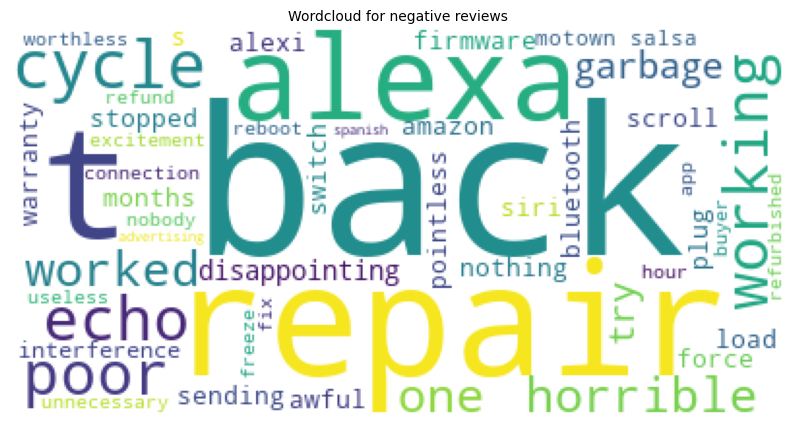

In [119]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

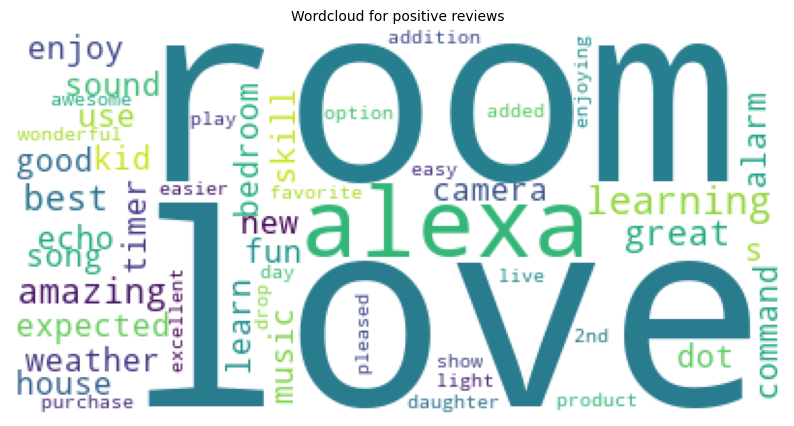

In [120]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [25]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [26]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [27]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/models-upsample/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [28]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [ ]:
# SMOTE technique

#Split the data into features and target variable

X = data.drop('feedback', axis=1)
y = data['feedback']

In [ ]:
X_train_smo.shape, X_test_smo.shape, y_train_smo.shape, y_test_smo.shape

In [30]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [31]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [32]:
#Saving the scaler model
pickle.dump(scaler, open('Models/models-upsample/scaler.pkl', 'wb'))

#### Random Forest

In [33]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [34]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9407407407407408


In [35]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [58]:
#Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_preds)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_preds))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.54      0.42        78
           1       0.96      0.91      0.93       867

    accuracy                           0.88       945
   macro avg       0.65      0.72      0.68       945
weighted avg       0.91      0.88      0.89       945



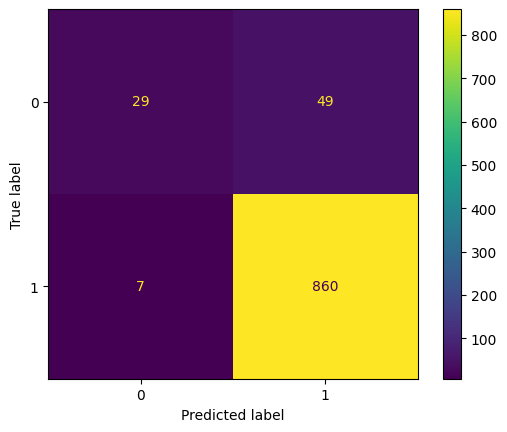

In [37]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [38]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9314911559029205
Standard Variance : 0.007130151838118036


Applying grid search to get the optimal parameters on random forest

In [39]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [41]:
#sol 1 for the runtime warning encountered in the grid search step in the next cell


X_train_scl = np.nan_to_num(X_train_scl)  # Replace NaN/Inf with finite numbers
y_train = np.nan_to_num(y_train).astype(int)  # Replace NaN/Inf and ensure integer labels

In [42]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

c:\Users\nilan\anaconda3\envs\amazon-alexa-reviews\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [43]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [44]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.76724137931035
Cross validation mean accuracy on test set : 92.16197822141561
Accuracy score for test set : 0.9407407407407408


#### XgBoost

In [45]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [47]:
y_preds = model_xgb.predict(X_test)

In [59]:
#Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_preds)
print(cm)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_preds))

[[ 42  36]
 [ 80 787]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.54      0.42        78
           1       0.96      0.91      0.93       867

    accuracy                           0.88       945
   macro avg       0.65      0.72      0.68       945
weighted avg       0.91      0.88      0.89       945



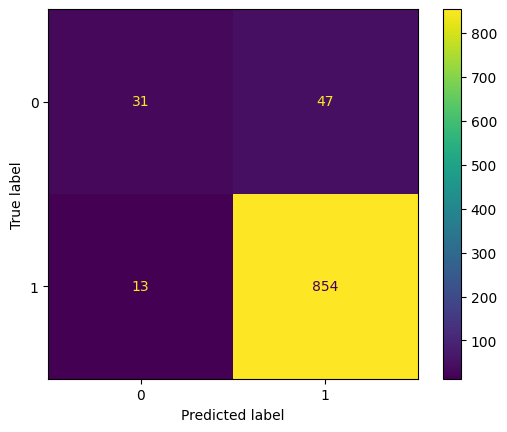

In [49]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [50]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/models-upsample/model_xgb.pkl', 'wb'))

# first save 
#model_xgb.save_model('model_name.json')
#Then load 
#loaded_bst = xgb.Booster()
#loaded_bst.load_model('model_name.json')

#### Decision Tree Classifier

In [51]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [52]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9216931216931217


In [53]:
y_preds = model_dt.predict(X_test)

In [54]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 42  36]
 [ 80 787]]


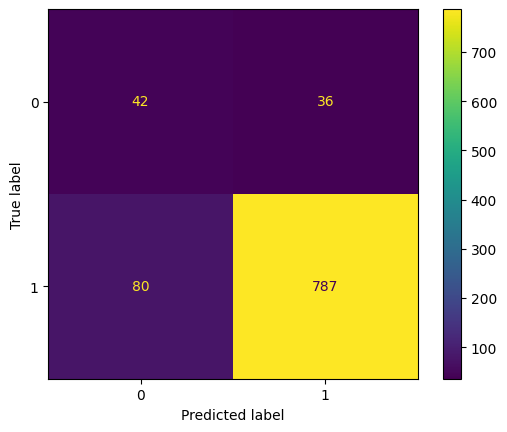

In [55]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()